# Data Exploration - Aprix Lead Scoring System

This notebook contains the exploratory data analysis for the Aprix lead scoring dataset.

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from scipy.stats import chi2_contingency
warnings.filterwarnings('ignore')
from scipy.stats import pearsonr
from scipy.stats import ks_2samp

plt.style.use('default')
sns.set_palette("husl")

## Data 

In [133]:
df = pd.read_excel('../data/raw/data.xlsx', sheet_name=1)
df['faturamento_anual_milhoes'] = df['faturamento_anual_milhoes'].apply(
    lambda x: float(x.day + x.month/10) if isinstance(x, datetime) else float(x)
)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Dataset shape: (300, 21)

Columns: ['company_id', 'company_name', 'segmento', 'faturamento_anual_milhoes', 'numero_SKUs', 'exporta', 'margem_media_setor', 'contact_role', 'lead_source', 'crm_stage', 'created_at', 'emails_enviados', 'emails_abertos', 'emails_respondidos', 'reunioes_realizadas', 'download_whitepaper', 'demo_solicitada', 'problemas_reportados_precificacao', 'urgencia_projeto', 'days_since_first_touch', 'converted']


## Target Variable Analysis

In [134]:
conversion_rate = df['converted'].mean()
total_leads = len(df)
converted_leads = df['converted'].sum()
non_converted_leads = total_leads - converted_leads

print(f"Overall Conversion Rate: {conversion_rate:.1%}")
print(f"Total Leads: {total_leads}")
print(f"Converted Leads: {converted_leads}")
print(f"Non-converted Leads: {non_converted_leads}")

Overall Conversion Rate: 48.0%
Total Leads: 300
Converted Leads: 144
Non-converted Leads: 156


## Categorical Features Analysis

In [135]:
segment_analysis = df.groupby('segmento').agg({
    'converted': ['count', 'sum', 'mean']
}).round(3)
segment_analysis.columns = ['Total_Leads', 'Converted', 'Conversion_Rate']
segment_analysis = segment_analysis.sort_values('Conversion_Rate', ascending=False)

print("Conversion by segmento:")
print(segment_analysis)

Conversion by segmento:
                         Total_Leads  Converted  Conversion_Rate
segmento                                                        
Energia & Utilities               41         23            0.561
Químicos & Plásticos              34         19            0.559
Bens de Consumo                   46         23            0.500
Máquinas & Equipamentos           40         19            0.475
Alimentos & Bebidas               47         21            0.447
Construção Civil                  37         16            0.432
Metalurgia                        55         23            0.418


In [136]:
role_analysis = df.groupby('contact_role').agg({
    'converted': ['count', 'sum', 'mean']
}).round(3)
role_analysis.columns = ['Total_Leads', 'Converted', 'Conversion_Rate']
role_analysis = role_analysis.sort_values('Conversion_Rate', ascending=False)

print("Conversion by contact_role:")
print(role_analysis)

Conversion by contact_role:
                          Total_Leads  Converted  Conversion_Rate
contact_role                                                     
Diretor de Operações               46         32            0.696
Gerente Comercial                  59         30            0.508
Analista de Precificação           44         22            0.500
Diretor Financeiro (CFO)           42         18            0.429
Gerente Financeiro                 51         20            0.392
Coordenador de Custos              58         22            0.379


In [137]:
source_analysis = df.groupby('lead_source').agg({
    'converted': ['count', 'sum', 'mean']
}).round(3)
source_analysis.columns = ['Total_Leads', 'Converted', 'Conversion_Rate']
source_analysis = source_analysis.sort_values('Conversion_Rate', ascending=False)

print("Conversion by lead_source:")
print(source_analysis)

Conversion by lead_source:
                      Total_Leads  Converted  Conversion_Rate
lead_source                                                  
Indicação de Cliente           62         34            0.548
Evento Setorial                66         35            0.530
Inbound (Site)                 54         26            0.481
Conteúdo Técnico               62         28            0.452
Prospecção Ativa               56         21            0.375


## Numerical Features Distribution

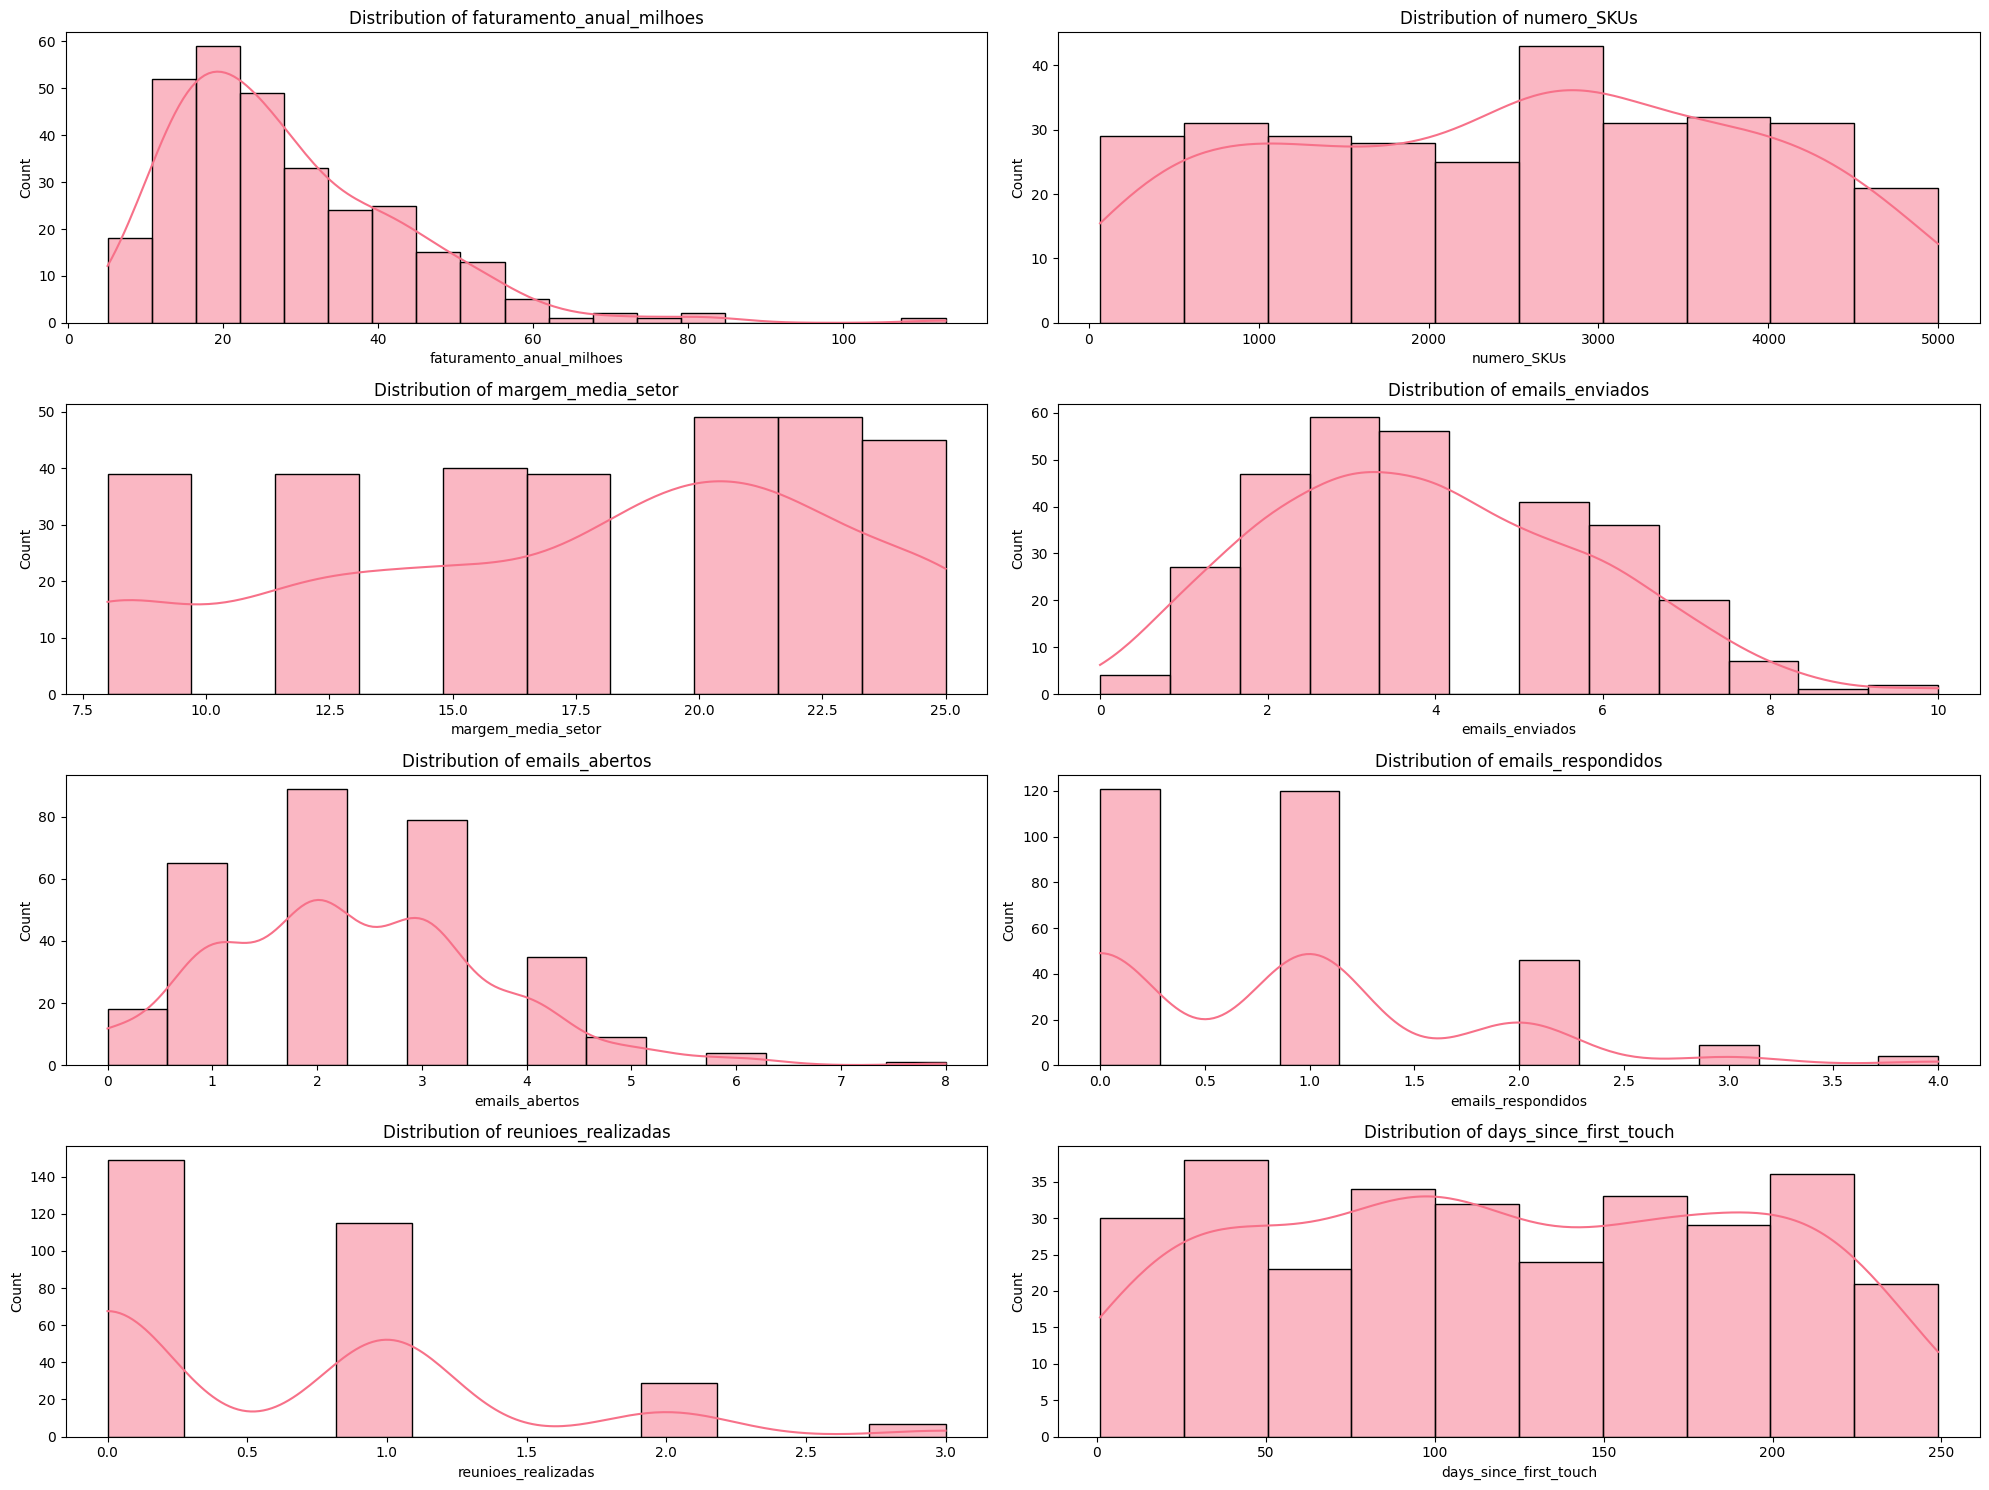

In [138]:
numerical_features = [
    'faturamento_anual_milhoes', 
    'numero_SKUs', 
    'margem_media_setor',
    'emails_enviados', 
    'emails_abertos', 
    'emails_respondidos',
    'reunioes_realizadas',
    'days_since_first_touch'
]

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data=df, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Summary Statistics

In [139]:
df['email_open_rate'] = np.where(df['emails_enviados'] > 0, 
                                df['emails_abertos'] / df['emails_enviados'], 0)
df['email_response_rate'] = np.where(df['emails_abertos'] > 0, 
                                    df['emails_respondidos'] / df['emails_abertos'], 0)
df['meeting_per_email_ratio'] = np.where(df['emails_enviados'] > 0,
                                        df['reunioes_realizadas'] / df['emails_enviados'], 0)

df['company_size_score'] = (
    (df['faturamento_anual_milhoes'] / df['faturamento_anual_milhoes'].max()) * 0.4 +
    (df['numero_SKUs'] / df['numero_SKUs'].max()) * 0.3 +
    (df['margem_media_setor'] / df['margem_media_setor'].max()) * 0.3
)

df['engagement_score'] = (
    df['email_open_rate'] * 0.2 +
    df['email_response_rate'] * 0.3 +
    (df['reunioes_realizadas'] / df['reunioes_realizadas'].max()) * 0.3 +
    df['download_whitepaper'] * 0.1 +
    df['demo_solicitada'] * 0.1
)

df['created_month'] = df['created_at'].dt.month
df['created_quarter'] = df['created_at'].dt.quarter
df['created_weekday'] = df['created_at'].dt.dayofweek
df['is_recent_lead'] = (df['days_since_first_touch'] <= 30).astype(int)

df['revenue_margin_interaction'] = df['faturamento_anual_milhoes'] * df['margem_media_setor']
df['size_complexity_interaction'] = df['faturamento_anual_milhoes'] * df['numero_SKUs']

df['is_high_value_segment'] = df['segmento'].isin(['Energia & Utilities', 'Químicos & Plásticos']).astype(int)
df['is_decision_maker'] = df['contact_role'].isin(['Diretor de Operações', 'Diretor Financeiro (CFO)']).astype(int)
df['is_warm_lead'] = df['lead_source'].isin(['Indicação de Cliente', 'Evento Setorial']).astype(int)

df['revenue_quartile'] = pd.qcut(df['faturamento_anual_milhoes'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df['sku_quartile'] = pd.qcut(df['numero_SKUs'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])


In [140]:
three_way = df.groupby(['segmento', 'contact_role', 'lead_source'])['converted'].agg(['count', 'mean']).round(3)
three_way.columns = ['Count', 'Conversion_Rate']
three_way = three_way[three_way['Count'] >= 3]

three_way.sort_values('Conversion_Rate', ascending=False)

Count  \
segmento                contact_role             lead_source                   
Alimentos & Bebidas     Diretor de Operações     Evento Setorial           3   
Energia & Utilities     Gerente Financeiro       Conteúdo Técnico          4   
Metalurgia              Gerente Comercial        Indicação de Cliente      4   
                        Diretor de Operações     Evento Setorial           4   
                        Gerente Comercial        Evento Setorial           3   
Alimentos & Bebidas     Gerente Comercial        Evento Setorial           3   
Energia & Utilities     Coordenador de Custos    Evento Setorial           3   
Máquinas & Equipamentos Gerente Financeiro       Conteúdo Técnico          3   
Bens de Consumo         Diretor Financeiro (CFO) Indicação de Cliente      3   
                        Diretor de Operações     Prospecção Ativa          3   
Metalurgia              Coordenador de Custos    Evento Setorial           3   
Construção Civil        Diretor Financeiro (CFO) Prospecção Ativa          3   
Bens de Consumo         Gerente Comercial        Indicação de Cliente      5   
Metalurgia              Coordenador de Custos    Indicação de Cliente      5   
Químicos & Plásticos    Coordenador de Custos    Conteúdo Técnico          5   
Metalurgia              Gerente Comercial        Inbound (Site)            3   
                        Diretor Financeiro (CFO) Inbound (Site)            3   
Energia & Utilities     Coordenador de Custos    Conteúdo Técnico          3   
Químicos & Plásticos    Diretor de Operações     Prospecção Ativa          3   
Energia & Utilities     Gerente Financeiro       Indicação de Cliente      3   
Alimentos & Bebidas     Diretor Financeiro (CFO) Evento Setorial           3   
Energia & Utilities     Analista de Precificação Prospecção Ativa          3   
Construção Civil        Gerente Comercial        Indicação de Cliente      3   
Alimentos & Bebidas     Gerente Financeiro       Evento Setorial           3   
                        Gerente Comercial        Indicação de Cliente      3   
Construção Civil        Diretor de Operações     Prospecção Ativa          4   
Bens de Consumo         Coordenador de Custos    Inbound (Site)            4   
Alimentos & Bebidas     Coordenador de Custos    Conteúdo Técnico          4   
Metalurgia              Analista de Precificação Prospecção Ativa          4   
Construção Civil        Coordenador de Custos    Conteúdo Técnico          3   
Máquinas & Equipamentos Coordenador de Custos    Conteúdo Técnico          3   

                                                                       Conversion_Rate  
segmento                contact_role             lead_source                            
Alimentos & Bebidas     Diretor de Operações     Evento Setorial                 1.000  
Energia & Utilities     Gerente Financeiro       Conteúdo Técnico                0.750  
Metalurgia              Gerente Comercial        Indicação de Cliente            0.750  
                        Diretor de Operações     Evento Setorial                 0.750  
                        Gerente Comercial        Evento Setorial                 0.667  
Alimentos & Bebidas     Gerente Comercial        Evento Setorial                 0.667  
Energia & Utilities     Coordenador de Custos    Evento Setorial                 0.667  
Máquinas & Equipamentos Gerente Financeiro       Conteúdo Técnico                0.667  
Bens de Consumo         Diretor Financeiro (CFO) Indicação de Cliente            0.667  
                        Diretor de Operações     Prospecção Ativa                0.667  
Metalurgia              Coordenador de Custos    Evento Setorial                 0.667  
Construção Civil        Diretor Financeiro (CFO) Prospecção Ativa                0.667  
Bens de Consumo         Gerente Comercial        Indicação de Cliente            0.600  
Metalurgia              Coordenador de Custos    Indicação de Cliente            0.400  
Químic

In [141]:
def categorize_revenue(revenue):
    if revenue < 10:
        return "Small (<10M)"
    elif revenue < 50:
        return "Medium (10-50M)"
    elif revenue < 100:
        return "Large (50-100M)"
    else:
        return "Enterprise (>100M)"

df['revenue_cohort'] = df['faturamento_anual_milhoes'].apply(categorize_revenue)

revenue_analysis = df.groupby('revenue_cohort').agg({
    'converted': ['count', 'sum', 'mean'],
    'faturamento_anual_milhoes': ['mean', 'median']
}).round(3)

revenue_analysis.columns = ['Total_Leads', 'Converted', 'Conversion_Rate', 'Avg_Revenue', 'Median_Revenue']
revenue_analysis = revenue_analysis.sort_values('Conversion_Rate', ascending=False)
revenue_analysis

,Total_Leads,Converted,Conversion_Rate,Avg_Revenue,Median_Revenue
revenue_cohort,,,,,
Large (50-100M),26,16,0.615,58.877,54.50
Small (<10M),14,8,0.571,7.957,8.05
Medium (10-50M),259,120,0.463,25.655,23.90
Enterprise (>100M),1,0,0.000,113.200,113.20


In [142]:
revenue_analysis['Potential_Revenue_Impact'] = (
    revenue_analysis['Converted'] * revenue_analysis['Avg_Revenue']
).round(2)

print("Revenue Impact by Cohort:")
revenue_analysis[['Conversion_Rate', 'Avg_Revenue', 'Potential_Revenue_Impact']].sort_values('Potential_Revenue_Impact', ascending=False)

Revenue Impact by Cohort:


,Conversion_Rate,Avg_Revenue,Potential_Revenue_Impact
revenue_cohort,,,
Medium (10-50M),0.463,25.655,3078.60
Large (50-100M),0.615,58.877,942.03
Small (<10M),0.571,7.957,63.66
Enterprise (>100M),0.000,113.200,0.00


In [143]:
sales_cycle_analysis = df.groupby('revenue_cohort').agg({
    'days_since_first_touch': ['mean', 'median', 'std', 'min', 'max'],
    'converted': 'mean'
}).round(2)

sales_cycle_analysis.columns = ['Avg_Days', 'Median_Days', 'Std_Days', 'Min_Days', 'Max_Days', 'Conversion_Rate']
print("Sales Cycle Length by Revenue Cohort:")
sales_cycle_analysis

Sales Cycle Length by Revenue Cohort:


,Avg_Days,Median_Days,Std_Days,Min_Days,Max_Days,Conversion_Rate
revenue_cohort,,,,,,
Enterprise (>100M),153.00,153.0,NaN,153,153,0.00
Large (50-100M),108.69,103.0,61.75,7,234,0.62
Medium (10-50M),121.00,116.0,71.18,1,249,0.46
Small (<10M),142.36,169.0,73.93,9,222,0.57


In [144]:
df['sales_cycle_bucket'] = pd.cut(df['days_since_first_touch'], 
                                 bins=[0, 30, 60, 90, 180, float('inf')], 
                                 labels=['0-30 days', '31-60 days', '61-90 days', '91-180 days', '180+ days'])

cycle_conversion = df.groupby('sales_cycle_bucket').agg({
    'converted': ['count', 'sum', 'mean'],
    'faturamento_anual_milhoes': 'mean'
}).round(3)

cycle_conversion.columns = ['Total_Leads', 'Converted', 'Conversion_Rate', 'Avg_Revenue']
print("Conversion Analysis by Sales Cycle Length:")
cycle_conversion

Conversion Analysis by Sales Cycle Length:


,Total_Leads,Converted,Conversion_Rate,Avg_Revenue
sales_cycle_bucket,,,,
0-30 days,39,29,0.744,28.182
31-60 days,36,18,0.500,25.294
61-90 days,36,16,0.444,26.692
91-180 days,112,51,0.455,30.495
180+ days,77,30,0.390,26.156


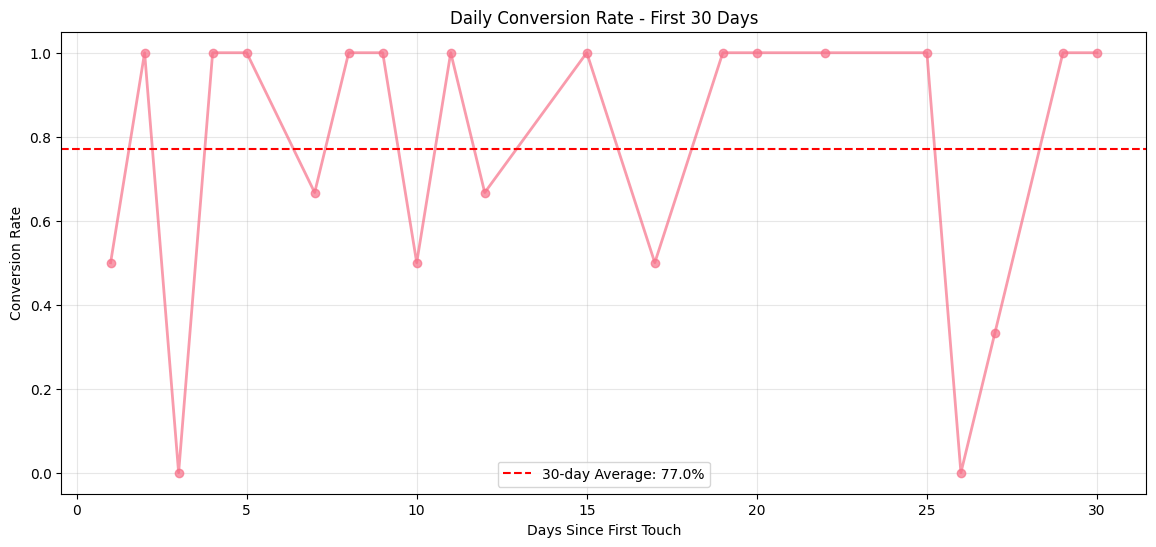

In [145]:
first_30_days = df[df['days_since_first_touch'] <= 30]
daily_conversion = first_30_days.groupby('days_since_first_touch').agg({
    'converted': ['count', 'sum', 'mean']
}).round(3)

daily_conversion.columns = ['Total_Leads', 'Converted', 'Conversion_Rate']

plt.figure(figsize=(14, 6))
plt.plot(daily_conversion.index, daily_conversion['Conversion_Rate'], 
         marker='o', linewidth=2, markersize=6, alpha=0.7)
plt.xlabel('Days Since First Touch')
plt.ylabel('Conversion Rate')
plt.title('Daily Conversion Rate - First 30 Days')
plt.grid(True, alpha=0.3)
plt.axhline(y=daily_conversion['Conversion_Rate'].mean(), color='red', linestyle='--', 
            label=f'30-day Average: {daily_conversion["Conversion_Rate"].mean():.1%}')
plt.legend()
plt.show()


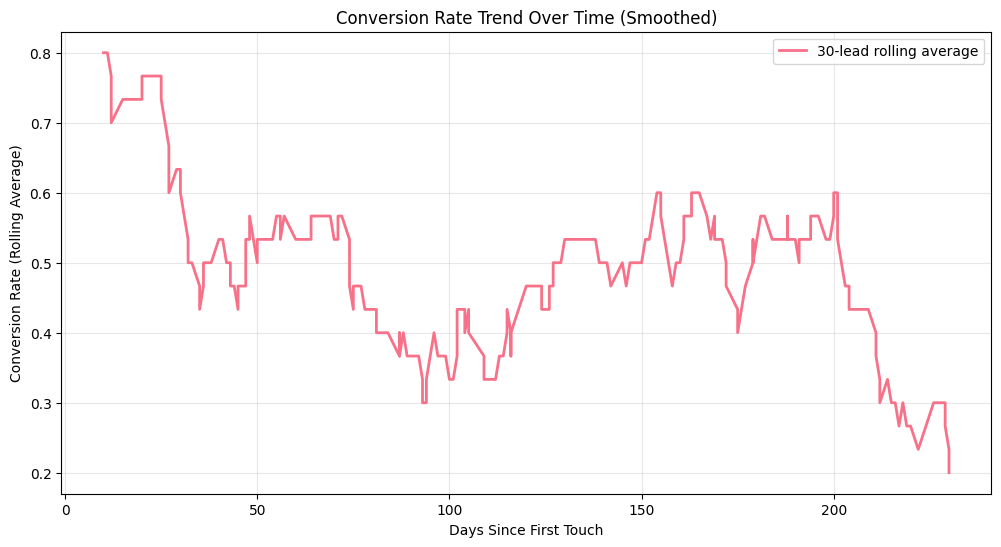

In [146]:
df_sorted = df.sort_values('days_since_first_touch')
window_size = 30

rolling_conversion = df_sorted['converted'].rolling(window=window_size, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_sorted['days_since_first_touch'], rolling_conversion, 
         linewidth=2, label=f'{window_size}-lead rolling average')
plt.xlabel('Days Since First Touch')
plt.ylabel('Conversion Rate (Rolling Average)')
plt.title('Conversion Rate Trend Over Time (Smoothed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [147]:
cross_analysis = df.groupby(['revenue_cohort', 'sales_cycle_bucket']).agg({
    'converted': ['count', 'mean']
}).round(3)

cross_analysis.columns = ['Lead_Count', 'Conversion_Rate']
cross_analysis_pivot = cross_analysis.reset_index().pivot(index='revenue_cohort', 
                                                         columns='sales_cycle_bucket', 
                                                         values='Conversion_Rate').fillna(0)
cross_analysis_pivot

sales_cycle_bucket,0-30 days,31-60 days,61-90 days,91-180 days,180+ days
revenue_cohort,,,,,
Enterprise (>100M),0.000,0.000,0.000,0.000,0.000
Large (50-100M),0.750,1.000,1.000,0.538,0.000
Medium (10-50M),0.735,0.419,0.406,0.447,0.397
Small (<10M),1.000,1.000,0.000,0.500,0.500


In [148]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_conversion = df.groupby('created_weekday').agg({
    'converted': ['count', 'sum', 'mean']
}).round(3)

weekday_conversion.columns = ['Total_Leads', 'Converted', 'Conversion_Rate']
weekday_conversion.index = [weekday_names[i] for i in weekday_conversion.index]
weekday_conversion

,Total_Leads,Converted,Conversion_Rate
Monday,36,19,0.528
Tuesday,43,22,0.512
Wednesday,39,15,0.385
Thursday,54,26,0.481
Friday,39,21,0.538
Saturday,54,23,0.426
Sunday,35,18,0.514


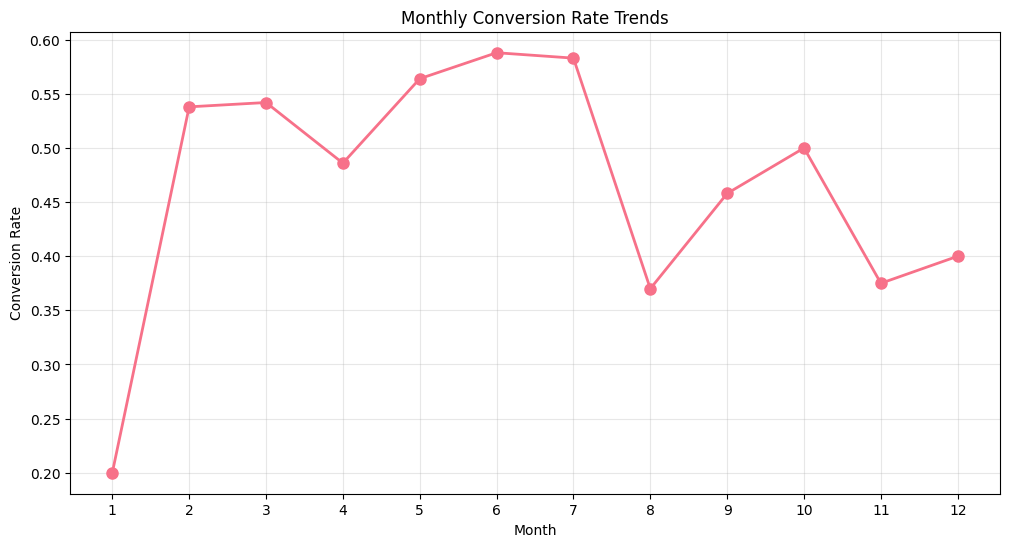

- Best converting month: Month 6 (58.8% conversion rate)
- Worst converting month: Month 1 (20.0% conversion rate)
- Seasonal variation: 38.8% difference between best and worst months


In [149]:
df['created_month'] = df['created_at'].dt.month
df['created_quarter'] = df['created_at'].dt.quarter
df['created_weekday'] = df['created_at'].dt.dayofweek
df['created_year'] = df['created_at'].dt.year

monthly_conversion = df.groupby('created_month').agg({
    'converted': ['count', 'sum', 'mean'],
    'faturamento_anual_milhoes': 'mean'
}).round(3)

monthly_conversion.columns = ['Total_Leads', 'Converted', 'Conversion_Rate', 'Avg_Revenue']
plt.figure(figsize=(12, 6))
plt.plot(monthly_conversion.index, monthly_conversion['Conversion_Rate'], 
         marker='o', linewidth=2, markersize=8)
plt.xlabel('Month')
plt.ylabel('Conversion Rate')
plt.title('Monthly Conversion Rate Trends')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.show()
best_month = monthly_conversion.loc[monthly_conversion['Conversion_Rate'].idxmax()]
worst_month = monthly_conversion.loc[monthly_conversion['Conversion_Rate'].idxmin()]

print(f"- Best converting month: Month {best_month.name} ({best_month['Conversion_Rate']:.1%} conversion rate)")
print(f"- Worst converting month: Month {worst_month.name} ({worst_month['Conversion_Rate']:.1%} conversion rate)")
print(f"- Seasonal variation: {(monthly_conversion['Conversion_Rate'].max() - monthly_conversion['Conversion_Rate'].min()):.1%} difference between best and worst months")


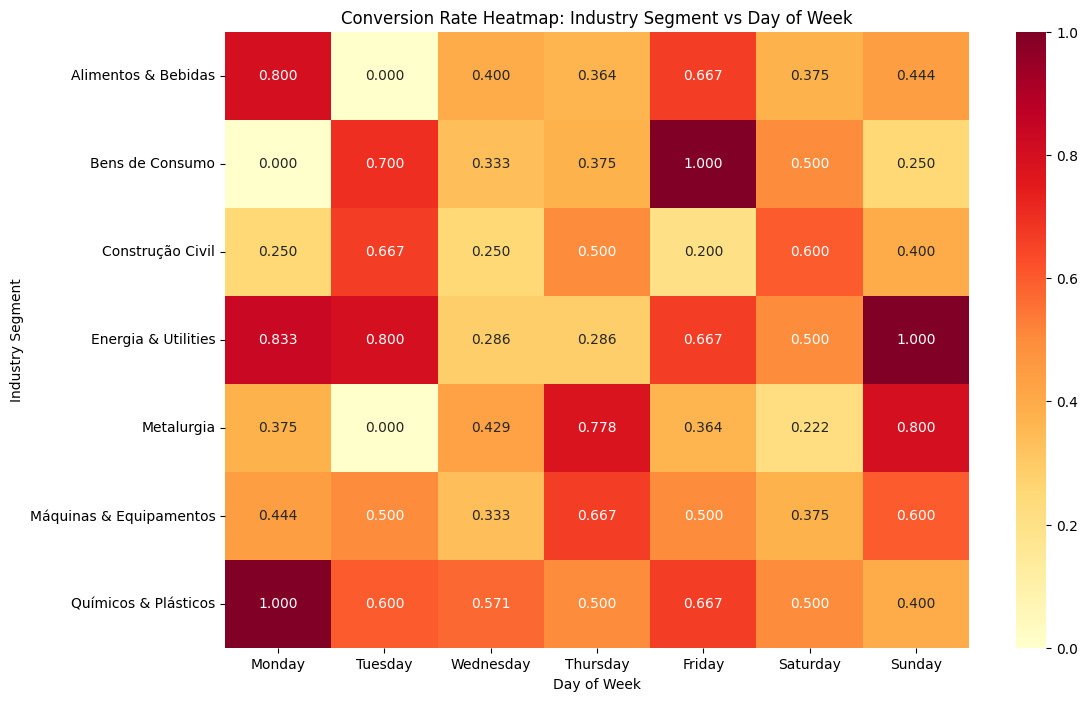

In [150]:
segment_weekday = df.groupby(['segmento', 'created_weekday']).agg({
    'converted': ['count', 'mean']
}).round(3)

segment_weekday.columns = ['Total_Leads', 'Conversion_Rate']
segment_weekday_pivot = segment_weekday.reset_index().pivot(
    index='segmento', columns='created_weekday', values='Conversion_Rate'
).fillna(0)

segment_weekday_pivot.columns = [weekday_names[i] for i in segment_weekday_pivot.columns]

segment_weekday_pivot

plt.figure(figsize=(12, 8))
sns.heatmap(segment_weekday_pivot, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Conversion Rate Heatmap: Industry Segment vs Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Industry Segment')
plt.show()


In [151]:
segment_penetration = df.groupby('segmento').agg({
    'converted': ['count', 'sum', 'mean'],
    'faturamento_anual_milhoes': ['mean', 'sum'],
    'margem_media_setor': 'mean'
}).round(3)

segment_penetration.columns = ['Total_Leads', 'Converted', 'Conversion_Rate',
                              'Avg_Revenue', 'Total_Revenue_Potential', 'Avg_Margin']

segment_penetration['Market_Opportunity_Score'] = (
    segment_penetration['Conversion_Rate'] * 
    segment_penetration['Avg_Revenue'] * 
    segment_penetration['Avg_Margin']
).round(2)

segment_penetration.sort_values('Market_Opportunity_Score', ascending=False)

,Total_Leads,Converted,Conversion_Rate,Avg_Revenue,Total_Revenue_Potential,Avg_Margin,Market_Opportunity_Score
segmento,,,,,,,
Energia & Utilities,41,23,0.561,30.259,1240.6,17.659,299.77
Químicos & Plásticos,34,19,0.559,25.674,872.9,19.765,283.66
Bens de Consumo,46,23,0.500,26.863,1235.7,17.196,230.97
Construção Civil,37,16,0.432,27.878,1031.5,18.486,222.63
Alimentos & Bebidas,47,21,0.447,30.534,1435.1,15.681,214.03
Metalurgia,55,23,0.418,27.602,1518.1,18.364,211.88
Máquinas & Equipamentos,40,19,0.475,26.652,1066.1,16.175,204.77


In [152]:
margin_analysis = df.groupby('segmento').agg({
    'margem_media_setor': ['mean', 'std', 'min', 'max'],
    'converted': 'mean',
    'faturamento_anual_milhoes': 'mean'
}).round(3)

margin_analysis.columns = ['Avg_Margin', 'Margin_Std', 'Min_Margin', 'Max_Margin',
                          'Conversion_Rate', 'Avg_Revenue']

margin_analysis['Competitive_Pressure'] = np.where(
    margin_analysis['Avg_Margin'] < margin_analysis['Avg_Margin'].median(),
    'High', 'Low'
)

margin_analysis

,Avg_Margin,Margin_Std,Min_Margin,Max_Margin,Conversion_Rate,Avg_Revenue,Competitive_Pressure
segmento,,,,,,,
Alimentos & Bebidas,15.681,5.619,8,25,0.447,30.534,High
Bens de Consumo,17.196,5.365,8,25,0.500,26.863,High
Construção Civil,18.486,5.450,8,25,0.432,27.878,Low
Energia & Utilities,17.659,5.494,8,25,0.561,30.259,Low
Metalurgia,18.364,5.390,8,25,0.418,27.602,Low
Máquinas & Equipamentos,16.175,5.007,8,25,0.475,26.652,High
Químicos & Plásticos,19.765,4.723,8,25,0.559,25.674,Low


In [153]:
df['prospect_score'] = (
    (df['faturamento_anual_milhoes'] / df['faturamento_anual_milhoes'].max()) * 0.3 +
    (df['email_open_rate']) * 0.2 +
    (df['reunioes_realizadas'] / df['reunioes_realizadas'].max()) * 0.2 +
    (df['download_whitepaper'] + df['demo_solicitada']) * 0.15 +
    (1 - df['days_since_first_touch'] / df['days_since_first_touch'].max()) * 0.15
)

top_prospects = df.nlargest(20, 'prospect_score')[['segmento', 'contact_role', 'lead_source',
                                                  'faturamento_anual_milhoes', 'prospect_score',
                                                  'converted']].round(3)
top_prospects


,segmento,contact_role,lead_source,faturamento_anual_milhoes,prospect_score,converted
232,Químicos & Plásticos,Coordenador de Custos,Indicação de Cliente,16.4,0.727,0
136,Metalurgia,Analista de Precificação,Prospecção Ativa,61.3,0.725,0
144,Químicos & Plásticos,Gerente Comercial,Conteúdo Técnico,18.2,0.704,0
119,Energia & Utilities,Analista de Precificação,Indicação de Cliente,40.9,0.686,1
170,Químicos & Plásticos,Gerente Comercial,Prospecção Ativa,82.3,0.684,1
236,Metalurgia,Analista de Precificação,Inbound (Site),113.2,0.641,0
159,Energia & Utilities,Analista de Precificação,Prospecção Ativa,62.7,0.636,1
28,Alimentos & Bebidas,Analista de Precificação,Inbound (Site),53.0,0.620,1
223,Máquinas & Equipamentos,Diretor Financeiro (CFO),Conteúdo Técnico,20.1,0.615,1
208,Metalurgia,Gerente Financeiro,Evento Setorial,24.4,0.615,0


In [154]:
from scipy.stats import ks_2samp

def ks_test_features(df, target_col, feature_cols):
    results = []
    for feature in feature_cols:
        converted_values = df[df[target_col] == 1][feature].dropna()
        non_converted_values = df[df[target_col] == 0][feature].dropna()
        
        if len(converted_values) > 0 and len(non_converted_values) > 0:
            ks_stat, p_value = ks_2samp(converted_values, non_converted_values)
            results.append({
                'feature': feature,
                'ks_statistic': ks_stat,
                'p_value': p_value,
                'converted_mean': converted_values.mean(),
                'non_converted_mean': non_converted_values.mean(),
                'difference': converted_values.mean() - non_converted_values.mean()
            })
    
    return pd.DataFrame(results).sort_values('ks_statistic', ascending=False)

key_features = [
    'faturamento_anual_milhoes',
    'numero_SKUs', 
    'margem_media_setor',
    'emails_enviados',
    'emails_abertos',
    'emails_respondidos',
    'reunioes_realizadas',
    'days_since_first_touch',
    'email_open_rate',
    'email_response_rate',
    'company_size_score',
    'engagement_score',
    'prospect_score'
]

ks_results_df = ks_test_features(df, 'converted', key_features)

ks_results_df['significance_level'] = ks_results_df['p_value'].apply(
    lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'ns'
)

ks_results_df['discrimination_strength'] = ks_results_df['ks_statistic'].apply(
    lambda x: 'Very Strong' if x >= 0.5 else 'Strong' if x >= 0.3 else 'Moderate' if x >= 0.1 else 'Weak'
)

print("KS Test Results DataFrame:")
ks_results_df


KS Test Results DataFrame:


,feature,ks_statistic,p_value,converted_mean,non_converted_mean,difference,significance_level,discrimination_strength
7,days_since_first_touch,0.166667,0.027018,108.666667,132.455128,-23.788462,*,Moderate
1,numero_SKUs,0.138889,0.099136,2686.652778,2345.493590,341.159188,ns,Moderate
8,email_open_rate,0.131410,0.135111,0.644764,0.709165,-0.064401,ns,Moderate
11,engagement_score,0.118590,0.220660,0.368432,0.353772,0.014660,ns,Moderate
0,faturamento_anual_milhoes,0.107906,0.319146,27.361111,28.589744,-1.228632,ns,Moderate
10,company_size_score,0.099893,0.410341,0.464914,0.455705,0.009209,ns,Weak
4,emails_abertos,0.099359,0.416933,2.229167,2.410256,-0.181090,ns,Weak
6,reunioes_realizadas,0.087073,0.583133,0.708333,0.589744,0.118590,ns,Weak
12,prospect_score,0.082265,0.652922,0.397808,0.380971,0.016837,ns,Weak
3,emails_enviados,0.074786,0.760560,3.944444,3.846154,0.098291,ns,Weak


## Outlier Analysis

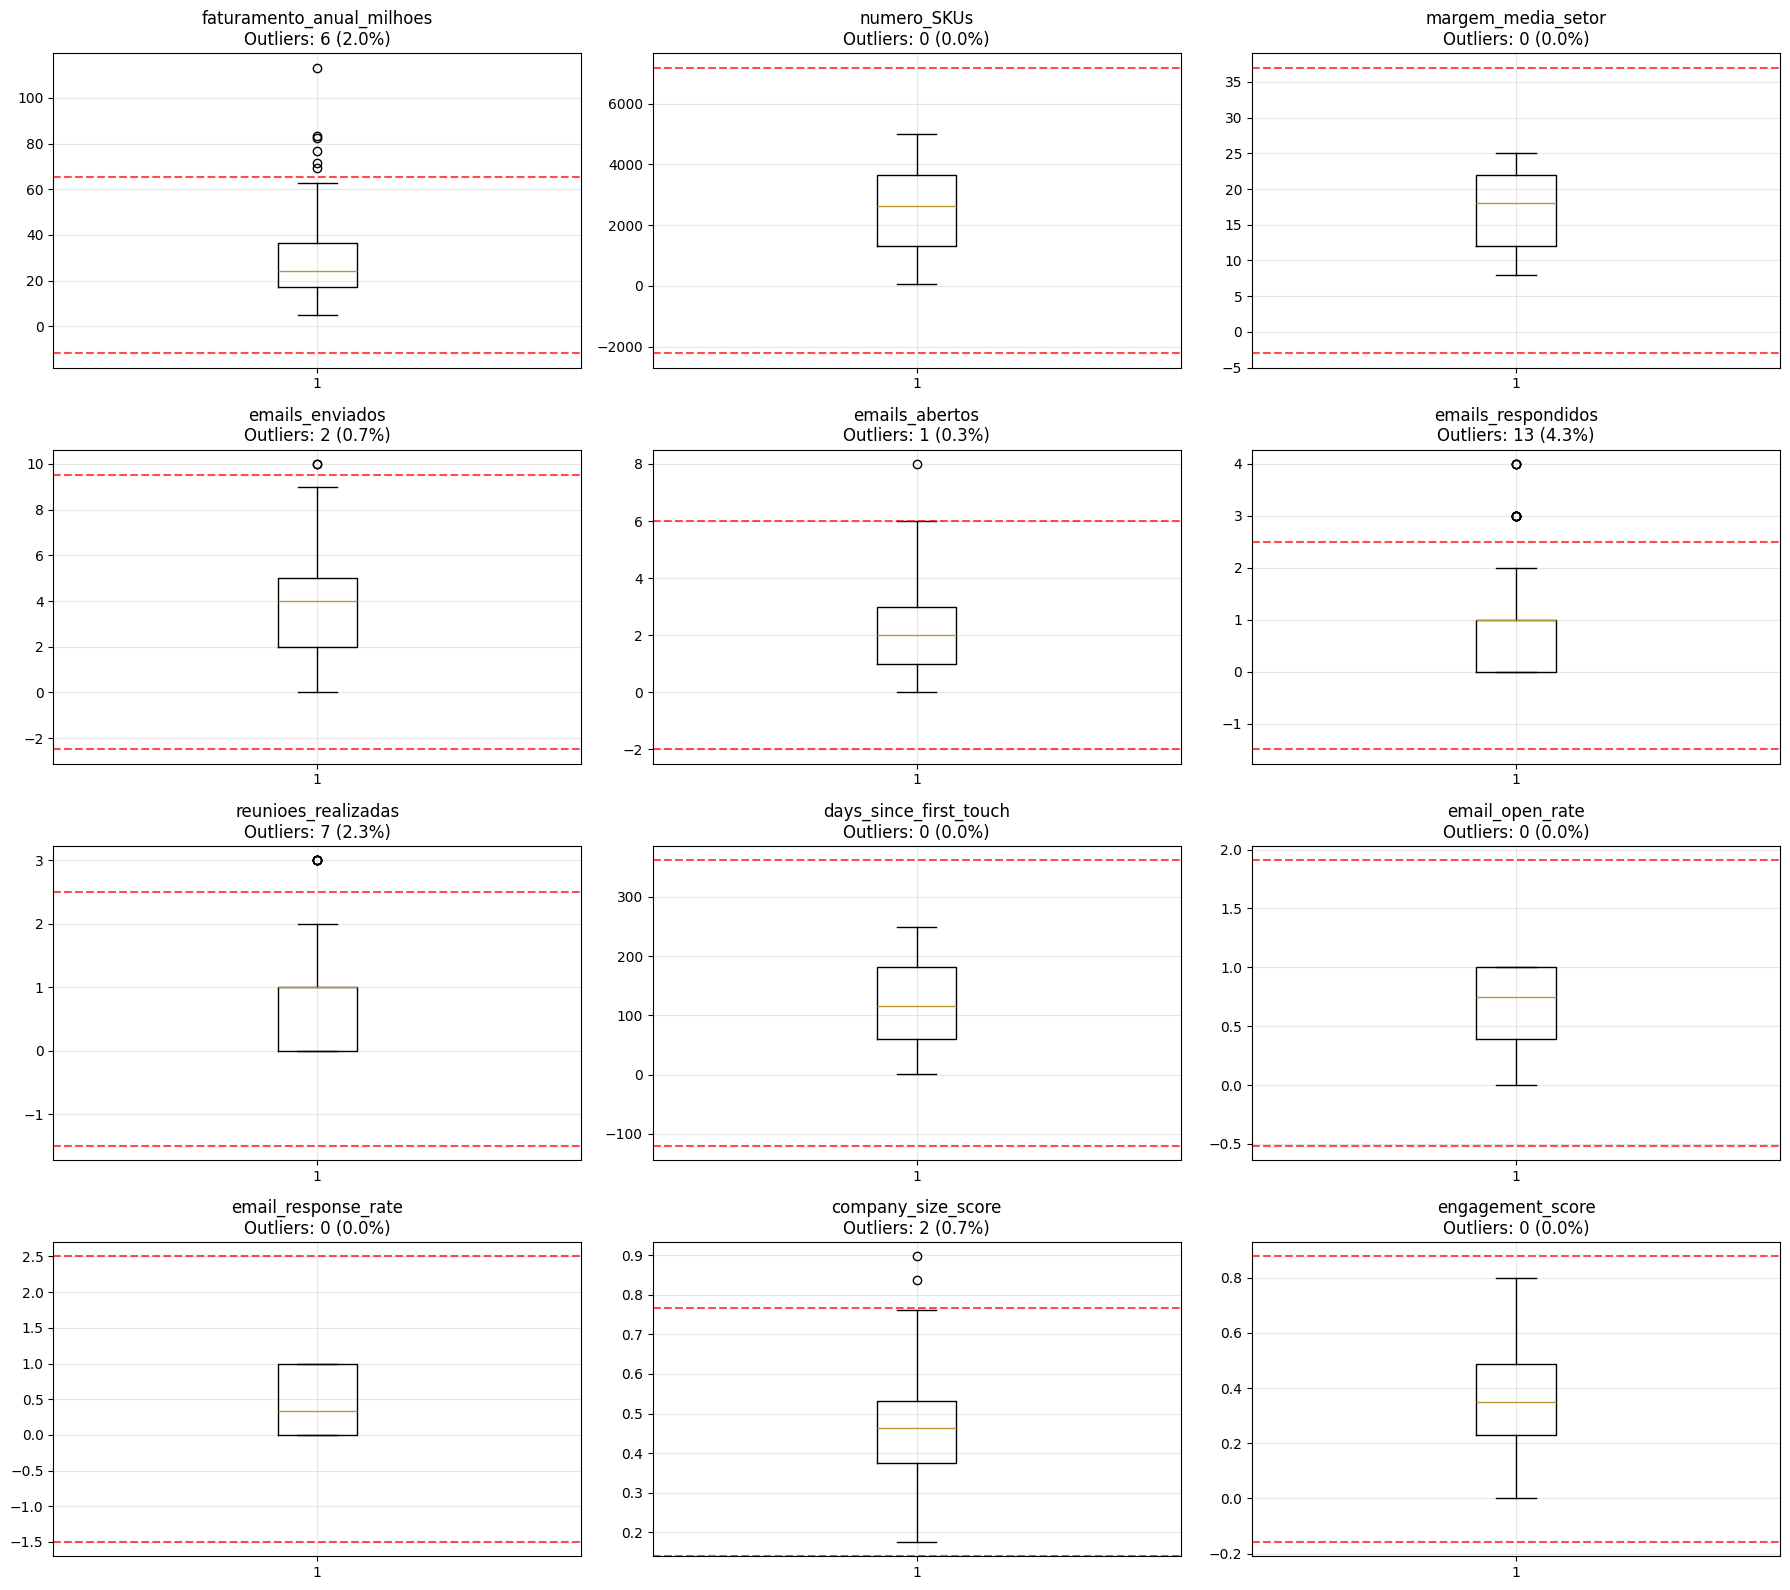

Outlier Impact on Conversion Rates:

No features with high outlier impact detected.

Outlier Treatment Analysis:


,feature,method,original_outliers,treated_outliers,original_std,treated_std,std_reduction
0,faturamento_anual_milhoes,capping,6,0,15.10,13.84,8.31
1,numero_SKUs,capping,0,0,1386.29,1386.29,0.00
2,days_since_first_touch,capping,0,0,70.47,70.47,0.00


In [162]:
def iqr_analysis(df, numerical_features, target_col='converted'):
    iqr_results = []
    
    for feature in numerical_features:
        data = df[feature].dropna()
        
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(data)) * 100
        
        converted_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][target_col].sum()
        total_outliers = len(df[(df[feature] < lower_bound) | (df[feature] > upper_bound)])
        outlier_conversion_rate = converted_outliers / total_outliers if total_outliers > 0 else 0
        
        normal_conversion_rate = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)][target_col].mean()
        
        iqr_results.append({
            'feature': feature,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outlier_count': outlier_count,
            'outlier_percentage': outlier_percentage,
            'outlier_conversion_rate': outlier_conversion_rate,
            'normal_conversion_rate': normal_conversion_rate,
            'conversion_difference': outlier_conversion_rate - normal_conversion_rate
        })
    
    return pd.DataFrame(iqr_results)

numerical_features_iqr = [
    'faturamento_anual_milhoes',
    'numero_SKUs', 
    'margem_media_setor',
    'emails_enviados',
    'emails_abertos',
    'emails_respondidos',
    'reunioes_realizadas',
    'days_since_first_touch',
    'email_open_rate',
    'email_response_rate',
    'company_size_score',
    'engagement_score'
]

iqr_results = iqr_analysis(df, numerical_features_iqr)
iqr_results.round(3)

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.ravel()

for i, feature in enumerate(numerical_features_iqr):
    data = df[feature].dropna()
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    axes[i].boxplot(data, vert=True)
    axes[i].axhline(y=lower_bound, color='red', linestyle='--', alpha=0.7, label='Lower Bound')
    axes[i].axhline(y=upper_bound, color='red', linestyle='--', alpha=0.7, label='Upper Bound')
    axes[i].set_title(f'{feature}\nOutliers: {((data < lower_bound) | (data > upper_bound)).sum()} ({((data < lower_bound) | (data > upper_bound)).mean()*100:.1f}%)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

outlier_impact = iqr_results[['feature', 'outlier_percentage', 'outlier_conversion_rate', 
                             'normal_conversion_rate', 'conversion_difference']].copy()

outlier_impact['impact_category'] = outlier_impact['conversion_difference'].apply(
    lambda x: 'High Positive' if x > 0.1 else 'Moderate Positive' if x > 0.05 else 
              'Neutral' if abs(x) <= 0.05 else 'Moderate Negative' if x > -0.1 else 'High Negative'
)

outlier_impact = outlier_impact.sort_values('conversion_difference', ascending=False)
print("Outlier Impact on Conversion Rates:")
outlier_impact

high_impact_outliers = outlier_impact[
    (outlier_impact['outlier_percentage'] > 5) & 
    (abs(outlier_impact['conversion_difference']) > 0.05)
]

if len(high_impact_outliers) > 0:
    print("\nFeatures with High Outlier Impact (>5% outliers AND >5% conversion difference):")
    print(high_impact_outliers[['feature', 'outlier_percentage', 'conversion_difference', 'impact_category']])
else:
    print("\nNo features with high outlier impact detected.")

def outlier_treatment_analysis(df, feature, method='cap'):
    data = df[feature].copy()
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    if method == 'cap':
        treated_data = data.clip(lower=lower_bound, upper=upper_bound)
    elif method == 'remove':
        treated_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    original_std = data.std()
    treated_std = treated_data.std()
    
    return {
        'original_outliers': ((data < lower_bound) | (data > upper_bound)).sum(),
        'treated_outliers': ((treated_data < lower_bound) | (treated_data > upper_bound)).sum(),
        'original_std': original_std,
        'treated_std': treated_std,
        'std_reduction': (original_std - treated_std) / original_std * 100
    }

treatment_results = []
for feature in ['faturamento_anual_milhoes', 'numero_SKUs', 'days_since_first_touch']:
    cap_result = outlier_treatment_analysis(df, feature, 'cap')
    treatment_results.append({
        'feature': feature,
        'method': 'capping',
        **cap_result
    })

treatment_df = pd.DataFrame(treatment_results)
print("\nOutlier Treatment Analysis:")
treatment_df.round(2)
